# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import random
import warnings

from utils import mape, mean_std_cross_val_scores

from extrucal.extrusion import throughput_cal

warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import shuffle
from tqdm import tqdm

import joblib

random.seed(0)

# 1. Introduction

The model was trained with `extruder_size` in the range from 20mm to 250mm with 10mm increment. The previous results showed that the model didn't perform good for 25mm extruder, which was not the size used for training the model. So, it is the purpose of this notebook to check if the model performs any better for the `extruder sizes` that were included in the train data.

# 2. Evaluation of Performances of Models w.r.t. Extruder Sizes

## 2.1. Model Load

In [2]:
after_catb = joblib.load("../models/optimized_catb_model.pkl")

## 2.2. Preparation of Dataset for Comparison

In [3]:
extruder_size = []
for i in range(20, 256, 5):
    extruder_size.extend([i] * 10)

metering_depth_percent = [0.05] * 480
polymer_density = [1000] * 480
screw_pitch_percent = [1] * 480
flight_width_percent = [0.1] * 480
number_flight = [1] * 480
rpm = [
    r for r in range(0, 92, 10)
] * 48

In [4]:
df = pd.DataFrame(
    {
        "extruder_size": extruder_size,
        "metering_depth_percent": metering_depth_percent,
        "polymer_density": polymer_density,
        "screw_pitch_percent": screw_pitch_percent,
        "flight_width_percent": flight_width_percent,
        "number_flight": number_flight,
        "rpm": rpm,
    }
)

df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

new_col_order = [
    "extruder_size",
    "metering_depth",
    "polymer_density",
    "rpm",
    "screw_pitch",
    "flight_width",
    "number_flight",
]

df = df[new_col_order]

In [5]:
df["CatBoost_after"] = np.expm1(after_catb.predict(df))

In [6]:
df["extrucal"] = df.apply(
    lambda row: throughput_cal(
        row["extruder_size"],
        row["metering_depth"],
        row["polymer_density"],
        row["rpm"],
        row["screw_pitch"],
        row["flight_width"],
        int(row["number_flight"]),
    ),
    axis=1,
)

In [7]:
df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,CatBoost_after,extrucal
0,20,1.0,1000,0,20,2.0,1,-0.002010,0.00
1,20,1.0,1000,10,20,2.0,1,0.298645,0.29
2,20,1.0,1000,20,20,2.0,1,0.574028,0.59
3,20,1.0,1000,30,20,2.0,1,0.880247,0.88
4,20,1.0,1000,40,20,2.0,1,1.194390,1.18


## 2.3. Comparison of Throughputs

In [8]:
sizes_in_train_data = list(range(20, 251, 20))  # Just for display, interval of 20 was used
sizes_not_in_train_data = list(range(25, 256, 20))

### 2.3.1. `extruder_size` in Train Data

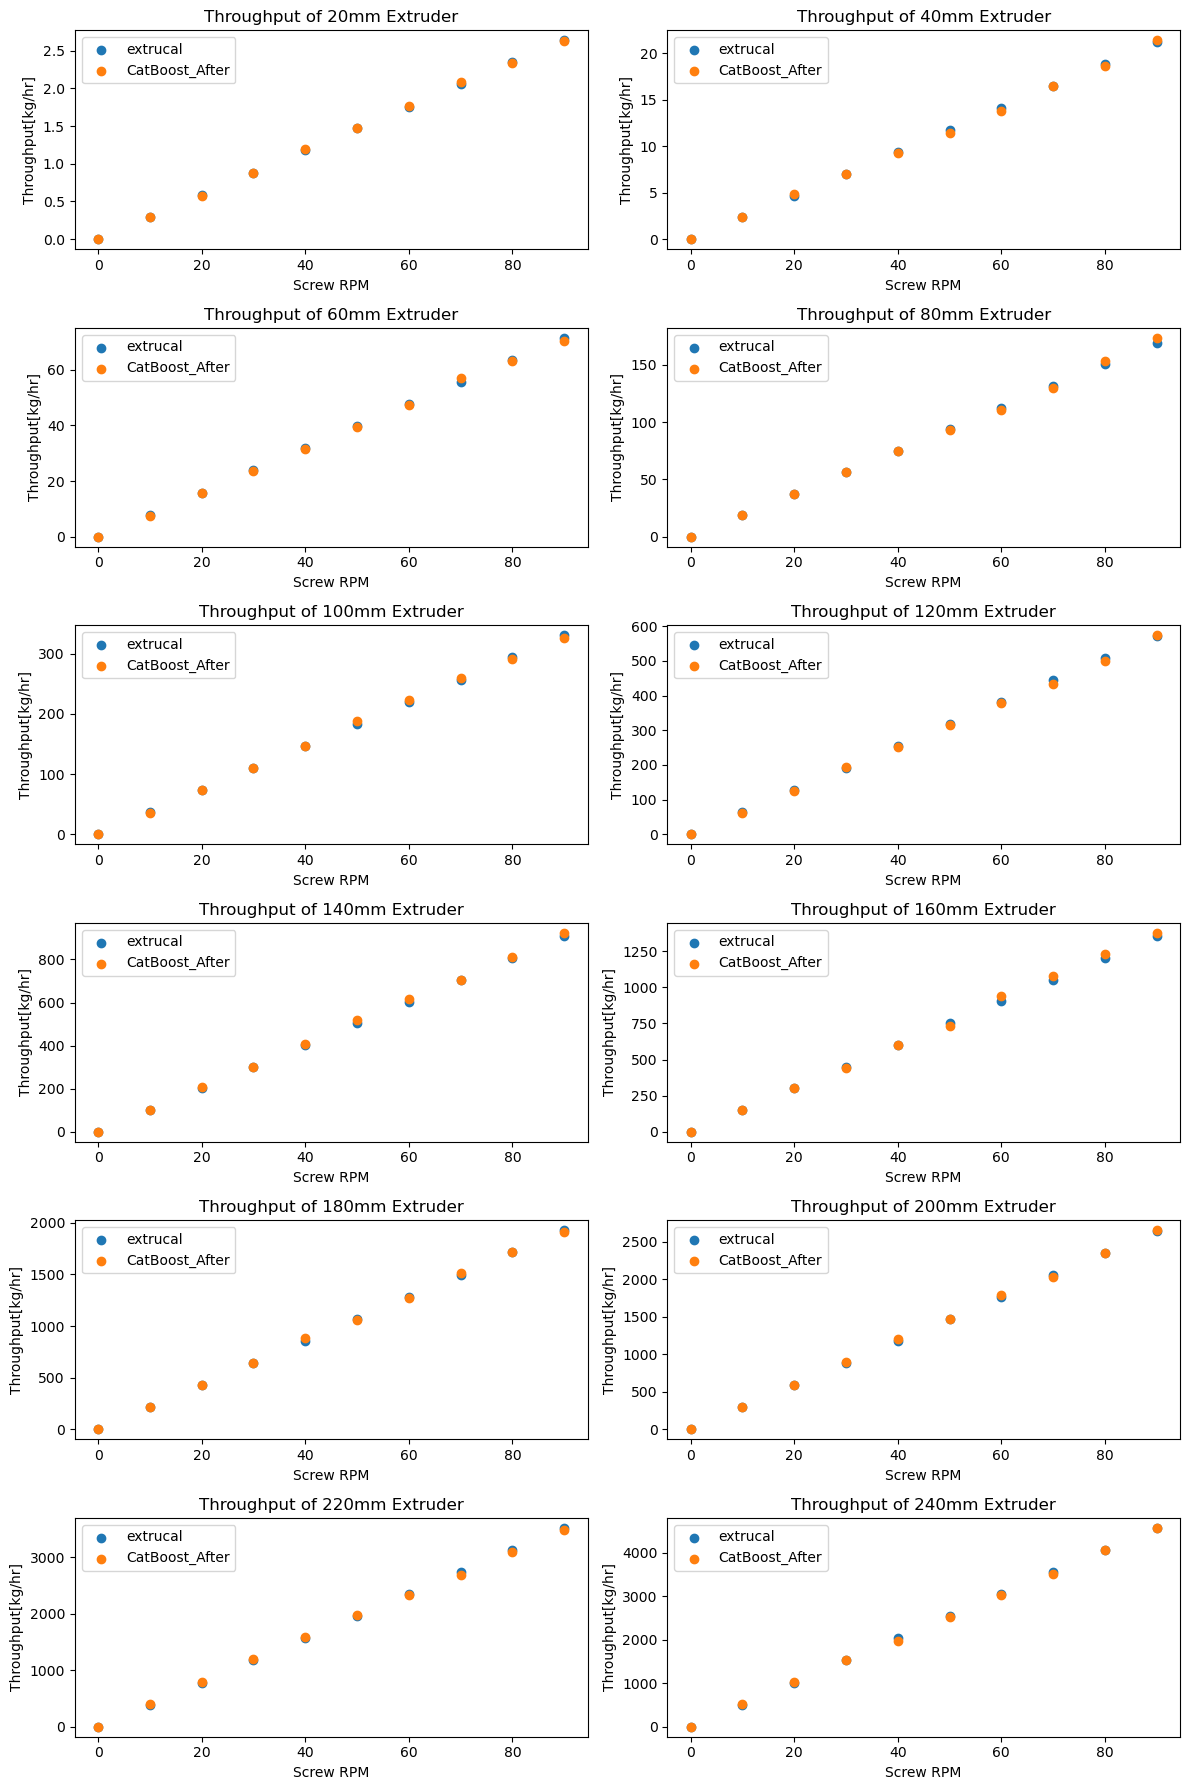

In [9]:
fig, axs = plt.subplots(figsize=(12, 18), nrows=6, ncols=2)
r = 0
c = 0
for size in sizes_in_train_data:
    temp = df.query(f"extruder_size == {size}")
    axs[r, c].scatter(temp["rpm"], temp["extrucal"], label="extrucal")
    axs[r, c].scatter(temp["rpm"], temp["CatBoost_after"], label="CatBoost_After")
    axs[r, c].set_title(f"Throughput of {size}mm Extruder")
    axs[r, c].set_xlabel("Screw RPM")
    axs[r, c].set_ylabel("Throughput[kg/hr]")
    axs[r, c].legend()
    if c < 1:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

The throughputs predicted by the model are almost identical to those by analytical solution(i.e. by `extrucal` library) for the `extruder_size` that were in Train Data.

### 2.3.2. `extruder_size` not in Train Data

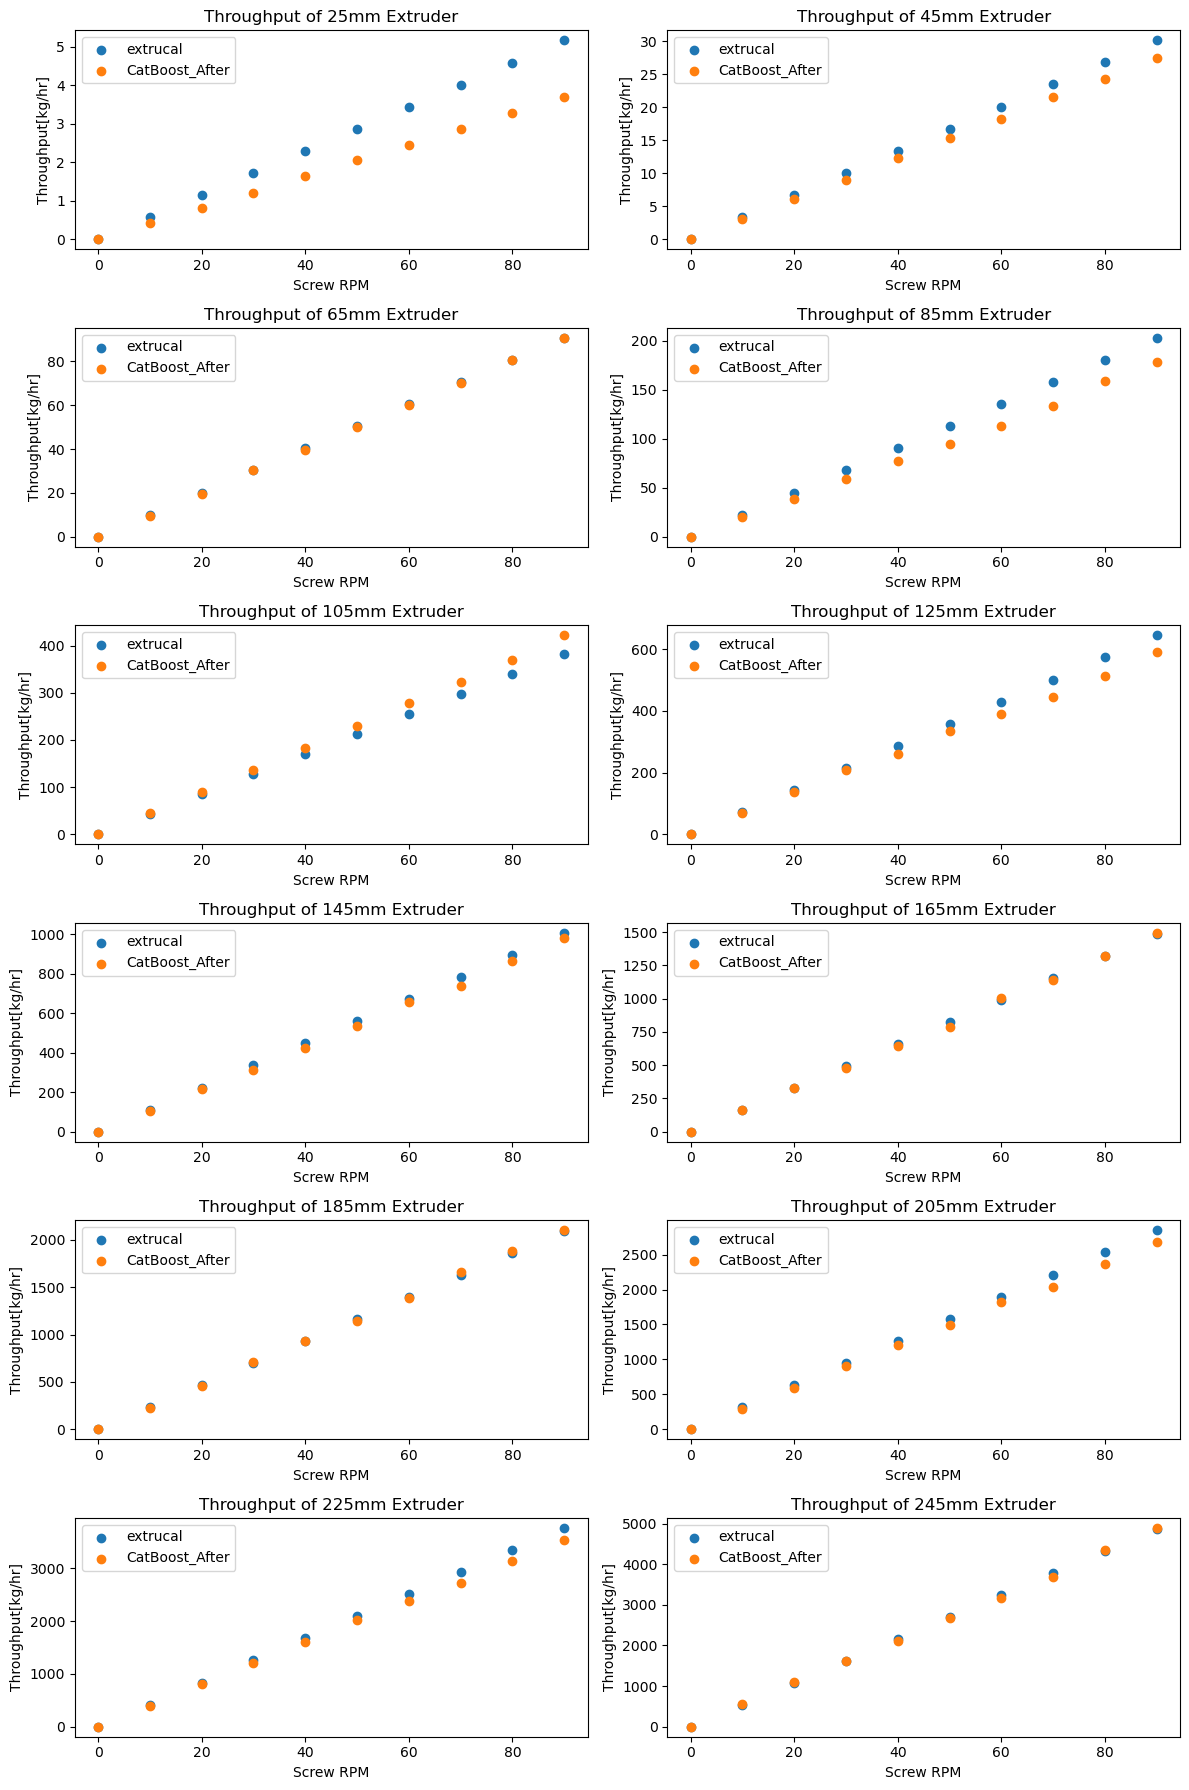

In [10]:
fig, axs = plt.subplots(figsize=(12, 18), nrows=6, ncols=2)
r = 0
c = 0
for size in sizes_not_in_train_data:
    temp = df.query(f"extruder_size == {size}")
    axs[r, c].scatter(temp["rpm"], temp["extrucal"], label="extrucal")
    axs[r, c].scatter(temp["rpm"], temp["CatBoost_after"], label="CatBoost_After")
    axs[r, c].set_title(f"Throughput of {size}mm Extruder")
    axs[r, c].set_xlabel("Screw RPM")
    axs[r, c].set_ylabel("Throughput[kg/hr]")
    axs[r, c].legend()
    if c < 1:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

There are disparities between the throughputs predicted by the model and those by analytical solution(i.e. by `extrucal` library) for the `extruder_size` that were not in Train Data. The disparity was bigger for the smallest extruder(i.e. 25mm) maybe because its throughputs were order of magnitude smaller than other sizes, and `MSE` was used as the evaluation metric.

## 2.4. Comparison of `MAPE` for Two Cases

In [11]:
df_in = df.query("extruder_size in @sizes_in_train_data")
df_not_in = df.query("extruder_size in @sizes_not_in_train_data")

In [12]:
mape(df_in["extrucal"], df_in["CatBoost_after"])

1.3310837963248687

In [13]:
mape(df_not_in["extrucal"], df_not_in["CatBoost_after"])

6.675245120829362

Significant difference in `MAPE` is observed between `extruder_size` in in Train Data and those not in Train Data.

# 3. Conclusion

In the beginning, this study started with a simple purpose of just demonstrating that machine learning model can learn very complicated pattern and can perform as well as an analytical solution. However, while I was working on modeling, I found out that the model didn't perform well for the smallest extruder (i.e. 25mm). Initially, I thought that it was due to the fact that the throughputs at zero screw RPM were included in the train data. I also suspected that either the log transformation of the throughput might have affected the performance of the model (because the distribution of throughputs after log transformation looked really weird) or the throughputs of the 25mm extruder were just too small to be considered significant by the model. In the end, it was clear that, since `CatBoostRegresser`, which is a tree-based model, was used, the errors for the `extruder_size` that were not included in the train data were higher than those sizes that were included in the train data. In conclusion, I was happy that I learned again another piece of machine learning, which taught me that I should always be careful with the data which are not included in the train data, while predicting using tree-based models.